In [9]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
from scipy.stats import uniform
import matplotlib.patches as mpatches
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler

In [15]:
# Sample data from distribution (sklearn)
circles_X, circles_y = make_circles(n_samples=500, noise=0.05)
df = pd.DataFrame(dict(x1=circles_X[:,0], x2=circles_X[:,1], label=circles_y))
df

,x1,x2,label
0,-0.176752,-1.065852,0
1,0.575423,-0.568814,1
2,0.086545,-1.015863,0
3,-0.168666,1.046268,0
4,0.155902,0.692463,1
...,...,...,...
495,0.224985,-0.758680,1
496,-0.735995,-0.244094,1
497,-0.677342,0.354396,1
498,-0.954904,-0.333337,0


In [16]:
#Classify with SVM
scaler = MinMaxScaler()
df[["x1", "x2"]] = scaler.fit_transform(df[["x1", "x2"]])
X_train, X_test, y_train, y_test = train_test_split(df[["x1", "x2"]], df["label"], test_size=0.2, random_state=0)

# Without Tuning
clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f1_score(y_test, y_pred, average="weighted"))
test = pd.DataFrame(data={'predictions': y_pred, 'actual': y_test})
test

0.96


,predictions,actual
90,1,1
254,1,1
283,0,0
445,0,0
461,1,1
...,...,...
372,1,1
56,0,0
440,1,1
60,0,0


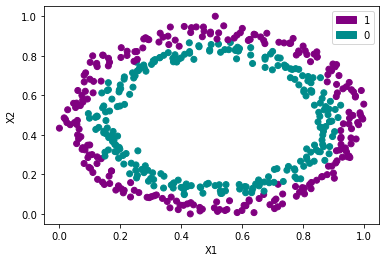

In [17]:
fig, ax = plt.subplots()
colors = {0:'purple', 1:'darkcyan'}
ax.scatter(df['x1'], df['x2'], c=df["label"].map(colors))

purple_patch = mpatches.Patch(color='purple', label='1')
cyan_patch = mpatches.Patch(color='darkcyan', label='0')
plt.legend(handles=[purple_patch, cyan_patch])

plt.xlabel("X1")
plt.ylabel("X2")

plt.savefig("truelabels.pdf")
plt.show()

In [18]:
# Store datasets in dictionary to simplify acccess
datasets = {}
datasets["circles"] = {"X": X_train, "X_names": ["x", "y"], "y": y_train, 
                       "y_name": "label", "df": df}

for dataset_name in datasets:
    scaler = MinMaxScaler()
    datasets[dataset_name]["X"] = scaler.fit_transform(datasets[dataset_name]["X"])
    X_train, X_test, y_train, y_test = train_test_split(datasets[dataset_name]["X"], datasets[dataset_name]["y"], test_size=0.2, random_state=0)

    #Define the search Grid
    grid = GridSearchCV(svm.SVC(random_state=0, class_weight="balanced"),
                      param_grid = {'kernel': ["rbf", "linear" "poly","sigmoid"],
                                    'C': [0.01, 0.1, 1, 10],
                                    'gamma': [1, 0.1, 0.01, 0.001, "scale"]
                                    },
                      cv = ShuffleSplit(n_splits=5, random_state=123),
                      verbose=10,
                      scoring='f1_micro',
                      n_jobs=-1)
    #Run the GridSearch
    results = grid.fit(X_train, y_train)
    df_results = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
    
    #Plot classification with default values and best values

    params={'default': {'kernel': "linear", 'C': 1,'gamma': "scale"},
            'best': {'kernel': results.best_params_["kernel"], 'C': results.best_params_["C"],'gamma': results.best_params_["gamma"]
                    }}

    configurations=["default", "best"]
    
    print(results.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.48125     nan 0.4625  0.4625      nan 0.45    0.44375     nan 0.44375
 0.44375     nan 0.44375 0.55        nan 0.4125  0.45        nan 0.45
 0.45        nan 0.45    0.45        nan 0.45    0.45        nan 0.45
 0.7         nan 0.43125 0.93125     nan 0.45625 0.45        nan 0.45
 0.45        nan 0.45    0.45        nan 0.45    0.975       nan 0.50625
 0.98125     nan 0.49375 0.49375     nan 0.41875 0.4375      nan 0.4375
 0.4375      nan 0.4375  0.975       nan 0.50625]
  warnings.warn(


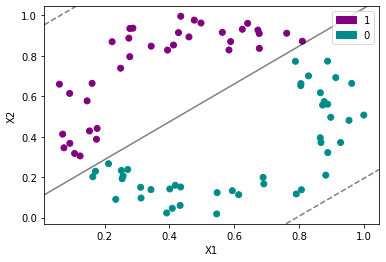

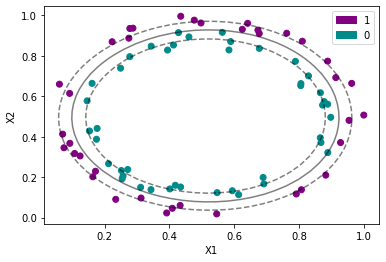

In [19]:
for configuration in configurations:

        # fit the model, don't regularize for illustration purposes
        clf = svm.SVC(class_weight="balanced", kernel=params[configuration]["kernel"], C=params[configuration]["C"], gamma=params[configuration]["gamma"], random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        test = pd.DataFrame(data={'predictions': y_pred, 'actual': y_test, 'x1':X_test[:,0], 'x2':X_test[:,1]})
        test

        
        fig, ax = plt.subplots()
        colors = {0:'purple', 1:'darkcyan'}
        ax.scatter(test['x1'], test['x2'], c=test["predictions"].map(colors))

        purple_patch = mpatches.Patch(color='purple', label='1')
        cyan_patch = mpatches.Patch(color='darkcyan', label='0')
        plt.legend(handles=[purple_patch, cyan_patch])
        
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
              linestyles=['--', '-', '--'])

        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.savefig("test{c}.pdf".format(c=configuration))
        plt.show()